In [12]:
#preprocess the text data
import pandas as pd
import nltk
import re
import stopwordsiso as stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df_psg = pd.read_excel('psg_sentiment_analysis_results.xlsx')
df_madrid = pd.read_excel('madrid_sentiment_analysis_results.xlsx')

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.stopwords('fr'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Return processed text
    return ' '.join(words)

# Preprocess the comments
df_psg['processed_text'] = df_psg['textDisplay'].apply(preprocess_text)
df_madrid['processed_text'] = df_madrid['textDisplay'].apply(preprocess_text)

# Check the processed text
print(df_psg[['textDisplay', 'processed_text']].head())
print(df_madrid[['textDisplay', 'processed_text']].head())


                                         textDisplay  \
0                   mbapp, dj une lgende pour vous ?   
1  @@aminatafall-o9p leader c est pas une legende...   
2                                      mbapp et bien   
3  yo mbapp quitte la nation va prendre ta formti...   
4  j'aime ce jouer de foot je suis ton plus grand...   

                                      processed_text  
0                                    mbapp dj lgende  
1           aminatafallop leader legende information  
2                                              mbapp  
3  yo mbapp quitte nation prendre formtion madrid...  
4                         jaime jouer foot grand fun  
                                         textDisplay  \
0  bravo kilou. guadeloupe france 971 real madrid...   
1  bonnes chances je suis catalent mais  je te so...   
2                         je suis barcelonais...mais   
3  bienvenue kilian mbap dans un grand club du monde   
4        nous sommes  la joie de km au real madrid . 

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

import stopwordsiso as stopwords

# Combine the processed text from both datasets 
comments = pd.concat([df_psg['processed_text'], df_madrid['processed_text']], axis=0)


# French stopwords list 
french_stop_words = list(stopwords.stopwords('fr'))


# TF-IDF Vectorizer 
vectorizer = TfidfVectorizer(stop_words=french_stop_words, max_features=5000)  # Limit to top 5000 features

X = vectorizer.fit_transform(comments)

# Check the shape of the TF-IDF matrix 
print(X.shape)  # ((number of comments, number of features)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


(6227, 5000)


In [14]:
from sklearn.decomposition import LatentDirichletAllocation


# Apply LDA  
lda = LatentDirichletAllocation(n_components=5, random_state=42)

lda.fit(X)

# Print the topics and their top words 
def print_top_words(model, vectorizer, n_top_words):

    for topic_idx, topic in enumerate(model.components_):

        print(f"Topic {topic_idx + 1}:")
        # Get the top words for the topic
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        print(" ".join(top_words))

# Display the top words for each topic
print_top_words(lda, vectorizer, 10)


Topic 1:
kylian interview trs cest mbapp belle homme vraiment maturit quil
Topic 2:
cest kyky an quil heureux petit respect champion prsident magnifique
Topic 3:
cest mbappe quil mbapp temp oui madrid mme real jaime
Topic 4:
cest france psg grand faire real mec pub kylian quil
Topic 5:
bonne meilleur monde chance club joueur cest madrid kylian mbapp


In [15]:
# Get the topic distribution for each comment
topic_distribution = lda.transform(X)

# Assign the most likely topic to each comment and add 1 to start from 1
dominant_topic = topic_distribution.argmax(axis=1) + 1

# Add the dominant topic as a new column
df_psg['dominant_topic'] = dominant_topic[:len(df_psg)]
df_madrid['dominant_topic'] = dominant_topic[len(df_psg):]

# Check the results
print(df_psg[['textDisplay', 'dominant_topic']].head())
print(df_madrid[['textDisplay', 'dominant_topic']].head())

                                         textDisplay  dominant_topic
0                   mbapp, dj une lgende pour vous ?               5
1  @@aminatafall-o9p leader c est pas une legende...               2
2                                      mbapp et bien               1
3  yo mbapp quitte la nation va prendre ta formti...               5
4  j'aime ce jouer de foot je suis ton plus grand...               3
                                         textDisplay  dominant_topic
0  bravo kilou. guadeloupe france 971 real madrid...               4
1  bonnes chances je suis catalent mais  je te so...               5
2                         je suis barcelonais...mais               1
3  bienvenue kilian mbap dans un grand club du monde               5
4        nous sommes  la joie de km au real madrid .               4


C:\Users\16254\AppData\Local\Temp\ipykernel_17980\886537347.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_psg, x='dominant_topic', palette='Set2')


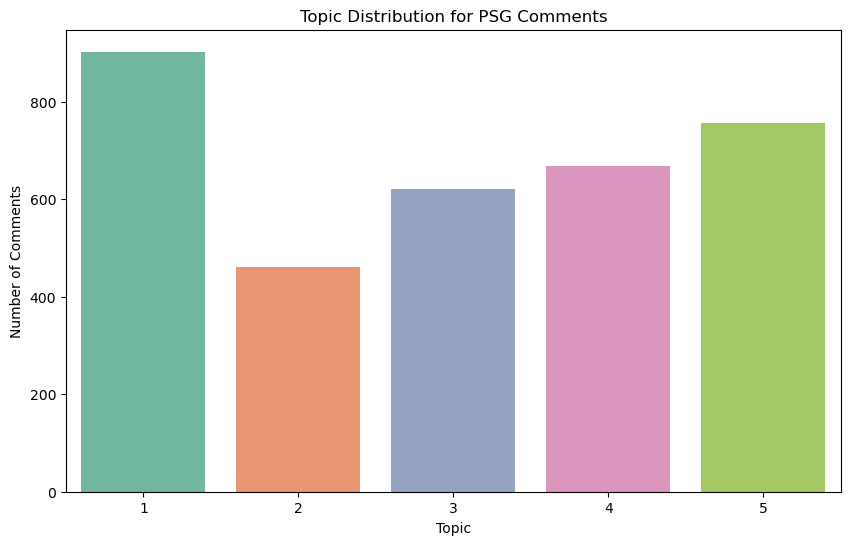

C:\Users\16254\AppData\Local\Temp\ipykernel_17980\886537347.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_madrid, x='dominant_topic', palette='Set2')


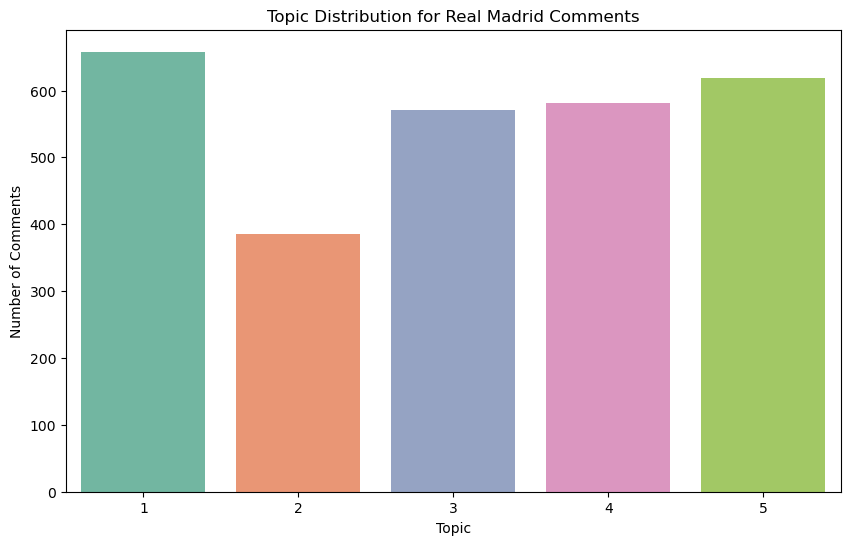

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot topic distribution for PSG 
plt.figure(figsize=(10, 6))
sns.countplot(data=df_psg, x='dominant_topic', palette='Set2')

plt.title('Topic Distribution for PSG Comments')
plt.xlabel('Topic')
plt.ylabel('Number of Comments')
plt.savefig('topic_distribution_for_psg')
plt.show()

# Plot topic distribution for Real Madrid 
plt.figure(figsize=(10, 6))
sns.countplot(data=df_madrid, x='dominant_topic', palette='Set2')

plt.title('Topic Distribution for Real Madrid Comments')
plt.xlabel('Topic')
plt.ylabel('Number of Comments')
plt.savefig('topic_distribution_for_madrid')
plt.show()


In [17]:
# Convert sentiment labels to numeric values for easier analysis
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df_psg['sentiment_numeric'] = df_psg['sentiment'].map(sentiment_map)
df_madrid['sentiment_numeric'] = df_madrid['sentiment'].map(sentiment_map)

# Check sentiment distribution by topic
df_psg['dominant_topic'] = dominant_topic[:len(df_psg)]  # Assign topic
df_madrid['dominant_topic'] = dominant_topic[len(df_psg):]  # Assign topic

# Calculate sentiment for each topic in PSG and Real Madrid
sentiment_by_topic_psg = df_psg.groupby('dominant_topic')['sentiment_numeric'].mean()
sentiment_by_topic_madrid = df_madrid.groupby('dominant_topic')['sentiment_numeric'].mean()

print(sentiment_by_topic_psg)
print(sentiment_by_topic_madrid)


dominant_topic
1    0.305648
2    0.030303
3   -0.006431
4   -0.049327
5    0.193122
Name: sentiment_numeric, dtype: float64
dominant_topic
1    0.162614
2   -0.103627
3   -0.064799
4   -0.201377
5    0.043619
Name: sentiment_numeric, dtype: float64


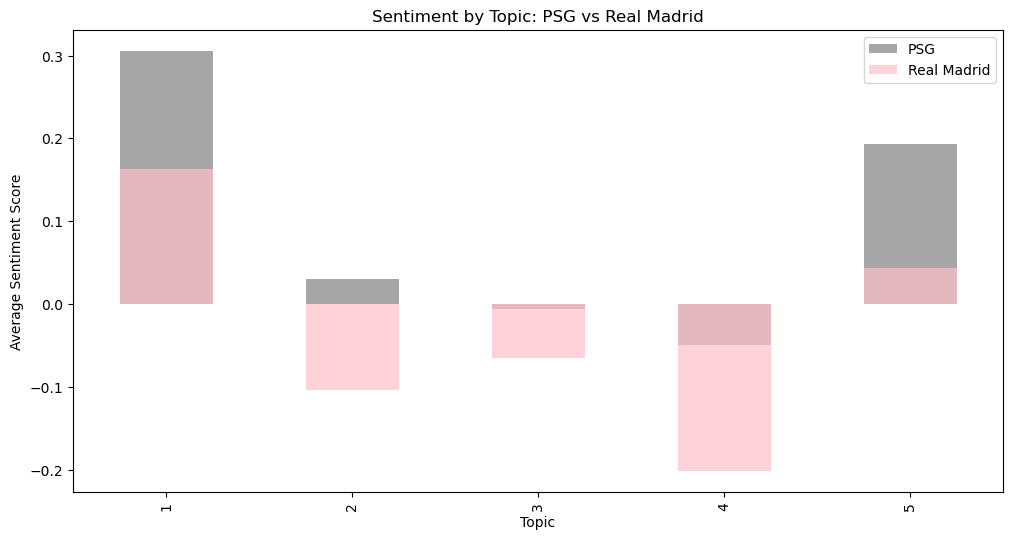

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment by topic for PSG and Real Madrid
plt.figure(figsize=(12, 6))
sentiment_by_topic_psg.plot(kind='bar', color='grey', alpha=0.7, label='PSG')
sentiment_by_topic_madrid.plot(kind='bar', color='pink', alpha=0.7, label='Real Madrid')
plt.title('Sentiment by Topic: PSG vs Real Madrid')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.savefig('sentiment_by_topic_psg_vs_madrid')
plt.show()
